In [540]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metric
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, make_scorer, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

# Ensemble (Various Type)
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Ensemble (Similar Type)
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from scipy.stats import kruskal, mannwhitneyu

# Converter Country to Continent
import country_converter as coco

import warnings
warnings.filterwarnings('ignore')

# **TRAVEL INSURANCE**
## Machine Learning Analytics by Sinabutar Yohanes Adolf Gusmories
------------

# `BUSINESS PROBLEM`

> **Context**

Asuransi perjalanan adalah jenis asuransi yang memberikan perlindungan selama kita melakukan perjalanan baik dalam negeri maupun luar negeri. Beberapa negara bahkan telah mewajibkan para *travelers* untuk memiliki asuransi perjalanan, misalnya negara-negara di Eropa dan Amerika. Besarnya premi tergantung dari pertanggungan yang diinginkan, lama perjalanan, dan tujuan perjalanan. Suatu perusahaan yang bergerak di bidang asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi untuk pertanggungan. Data pemegang polis pada perusahaan asuransi merupakan data historis yang terdiri dari destinasi, produk asuransi, dan sebagainya.

Target :

0 : Tidak klaim asuransi perjalanan

1 : Klaim asuransi perjalanan

> **Project Background**

Klaim asuransi perjalanan membutuhkan persiapan dana oleh perusahaan bilamana pemegang polis meminta pertanggungan. Perusahaan ingin meningkatkan efisiensi cadangan dana untuk alokasi terhadap pemegang polis yang mengajukan klaim, sehingga alokasi dana untuk pertanggungan tidak berlebih yang menyebabkan arus kas perusahaan tidak *liquid*


> **Goals**

Berdasarkan permasalahan tersebut, perusahaan ingin memprediksi kemungkinan pemegang polis asuransi akan klaim tanggungan atau tidak, sehingga alokasi dana tanggungan dapat disesuaikan oleh perusahaan dengan baik. Dari hal tersebut, perusahaan juga ingin mengetahui faktor atau ciri-ciri apa saja yang membuat pemegang polis mengajukan untuk klaim asuransi


> **Analytical Approach**

Analisis ini akan menemukan pola customer yang mengajukan klaim asuransi perjalanan dan yang tidak. Sehingga dibutuhkan model klasifikasi machine learning yang akan membantu perusahaan untuk dapat memprediksi probabilitas customer yang mengajukan klaim atau tidak. Dalam penggunaan kas perusahaan ini diasumsikan jika perusahaan akan mengalokasikan dana customer yang tidak klaim ke instrumen asuransi seperti Obligasi Negara dengan *capital gain* 6% per tahun.

> **Metric Evaluation**

![](confusion%20matrix.png)

Type 1 error : False Positive  
Konsekuensi: Kehilangan potensi *capital gain* investasi 6% YoY

Type 2 error : False Negative  
Konsekuensi: Adanya kerugian akibat membutuhkan dana mendadak, karena ternyata pemegang polis melakukan klaim sementara dana untuk pemegang polis ini belum disediakan sebelumnya

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi probabilitas terjadinya kekurangan cadangan kas yang sewaktu-waktu digunakan untuk pemegang polis yang klaim asuransi, tetapi tanpa mengurangi potensi *capital gain* investasi. Jadi kita ingin sebanyak mungkin prediksi kelas positif yang benar, dengan sesedikit mungkin prediksi *false negative*. Jadi nanti metric utama yang akan kita gunakan adalah **f2_score** karena akan menekan kelas *false negative* namun tetap tidak mengabaikan *false positive*.

Dalam hasil metric nantinya akan dilakukan perhitungan banyaknya cadangan kas yang harus disiapkan, dengan asumsi jumlah nominal klaim asuransi perjalanan tiap pemegang polis yaitu rata-rata dari total `Net Sales`

# `DATA UNDERSTANDING`

## `FEATURES`
| **Attribute** | **Description** |
| --- | --- |
| Agency | Name of agency. |
| Agency Type | Type of travel insurance agencies. |
| Distribution Channel | Channel of travel insurance agencies. |
| Product Name | Name of the travel insurance products. |
| Gender | Gender of insured. |
| Duration | Duration of travel. |
| Destination | Destination of travel. |
| Net Sales | Amount of sales of travel insurance policies. |
| Commission (in value) | Commission received for travel insurance agency. |
| Age | Age of insured. |
| Claim | Claim status. |

In [4]:
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [6]:
# Menampilkan jumlah missing value pada tiap feature
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

In [7]:
# Menampilkan ringkasan 
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(44328, 11)


,dataFeatures,dataType,null,unique,uniqueSample
0,Agency,object,0,16,"[TTW, ART]"
1,Agency Type,object,0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,2,"[Online, Offline]"
3,Product Name,object,0,26,"[Travel Cruise Protect, Annual Silver Plan]"
4,Gender,object,31647,2,"[M, nan]"
5,Duration,int64,0,437,"[512, 240]"
6,Destination,object,0,138,"[CYPRUS, TRINIDAD AND TOBAGO]"
7,Net Sales,float64,0,1006,"[116.5, 3.03]"
8,Commision (in value),float64,0,915,"[118.0, 15.0]"
9,Age,int64,0,89,"[33, 7]"


Summary Features<br>
Dari data tersebut dapat terlihat bahwa *missing value* berada pada kolom `Gender`, namun dalam proses analisis machine learning kali ini secara domain tidak ada pengaruh jenis kelamin terhadap kolom target (`Claim`). Karena apabila dilibatkan maka akan terjadi unsur subjektivitas dalam proses klaim asuransi. Selain itu, jumlah missing value yang banyak sekitar **62%** akan sulit diinterpretasikan jika menggunakan data kolom lainnya karena jenis kelamin merupakan faktor yang sifatnya *independent* / tidak dipengaruhi oleh aspek lainnya.

Oleh karena itu kolom `Gender` akan di *drop*

In [8]:
# Drop kolom Gender
df = df.drop(columns=['Gender'])

# `DATA CLEANING`

In [9]:
df.describe(include='all')

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
count,44328,44328,44328,44328,44328.000000,44328,44328.000000,44328.000000,44328.000000,44328
unique,16,2,2,26,NaN,138,NaN,NaN,NaN,2
top,EPX,Travel Agency,Online,Cancellation Plan,NaN,SINGAPORE,NaN,NaN,NaN,No
freq,24656,32113,43572,12979,NaN,9267,NaN,NaN,NaN,43651
mean,NaN,NaN,NaN,NaN,49.424292,NaN,40.550948,9.707692,39.925600,NaN
std,NaN,NaN,NaN,NaN,109.153961,NaN,48.661970,19.625637,13.954926,NaN
min,NaN,NaN,NaN,NaN,-1.000000,NaN,-357.500000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,9.000000,NaN,18.000000,0.000000,35.000000,NaN
50%,NaN,NaN,NaN,NaN,22.000000,NaN,26.500000,0.000000,36.000000,NaN
75%,NaN,NaN,NaN,NaN,53.000000,NaN,48.000000,11.550000,43.000000,NaN


## `Negative Values`
Dari deskripsi diatas terlihat bahwa ada nilai negatif pada kolom `Duration` dan `Net Sales`, namun nilai ini tidak relevan jika terdapat nilai negatif. Karena itu mari kita lihat data dari kolom tersebut yang menampilkan nilai negatif.

In [10]:
# Kolom Duration bernilai negatif
df[df['Duration'] < 0]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
26228,JZI,Airlines,Online,Basic Plan,-1,MALAYSIA,18.0,6.3,118,No
26494,JZI,Airlines,Online,Basic Plan,-1,BRUNEI DARUSSALAM,18.0,6.3,118,No


Negative Value in `Duration`<br>
Secara harfiah tidak mungkin durasi perjalanan pada kolom `Duration` itu negatif, karena kolom ini berkaitan dengan waktu yang seharusnya tidak bernilai negatif. Karena itu data yang bernilai negatif ini akan dihapus

In [11]:
# Menghapus data Duration bernilai negatif
df.drop(df[df['Duration'] < 0].index, inplace=True)

Negative Value in `Net Sales`<br>
Berikut data yang menampilkan nilai negatif pada kolom `Net Sales`

In [12]:
# Kolom Net Sales bernilai negatif
df[df['Net Sales'] < 0]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,77,JAPAN,-29.70,17.82,59,No
199,EPX,Travel Agency,Online,Cancellation Plan,29,HONG KONG,-12.00,0.00,36,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,57,AUSTRALIA,-59.40,35.64,28,No
...,...,...,...,...,...,...,...,...,...,...
43694,EPX,Travel Agency,Online,2 way Comprehensive Plan,140,UNITED STATES,-98.00,0.00,29,No
43743,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,23,MALAYSIA,-29.70,17.82,29,No
43751,EPX,Travel Agency,Online,2 way Comprehensive Plan,147,SPAIN,-68.00,0.00,36,No
43858,EPX,Travel Agency,Online,Cancellation Plan,49,UNITED KINGDOM,-68.00,0.00,36,No


In [13]:
# Status klaim pada data yang memiliki nilai negatif pada kolom Net Sales
df[df['Net Sales'] < 0]['Claim'].unique()

array(['No'], dtype=object)

Begitu pula dengan kolom `Net Sales` yang merupakan hasil penjualan dari produk jasa asuransi ini. Jika diasumsikan bernilai negatif berarti pihak perusahaan memberikan hasil penjualannya terhadap customer, yang mana tidak relevan jika bernilai negatif dan juga bukan merupakan dekripsi dari keuntungan atau kerugian. Selain itu jika diasumsikan dipengaruhi oleh kolom `Claim` status, data yang bernilai negatif ini tidak mengajukan klaim asuransi perjalanan.
Oleh karena itu, data yang memiliki nilai negatif pada kolom `Net Sales` ini akan dihapus karena jumlah data ini hanya sebanyak **1%** dari total data.

In [14]:
# Mengahpus kolom Net Sales bernilai negatif
df.drop(df[df['Net Sales'] < 0].index, inplace=True)

## `Outliers`
Mengecek outliers pada kolom numerical

In [15]:
# Kolom kategorikal
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Destination',
 'Claim']

In [16]:
# Kolom numerikal
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['Duration', 'Net Sales', 'Commision (in value)', 'Age']

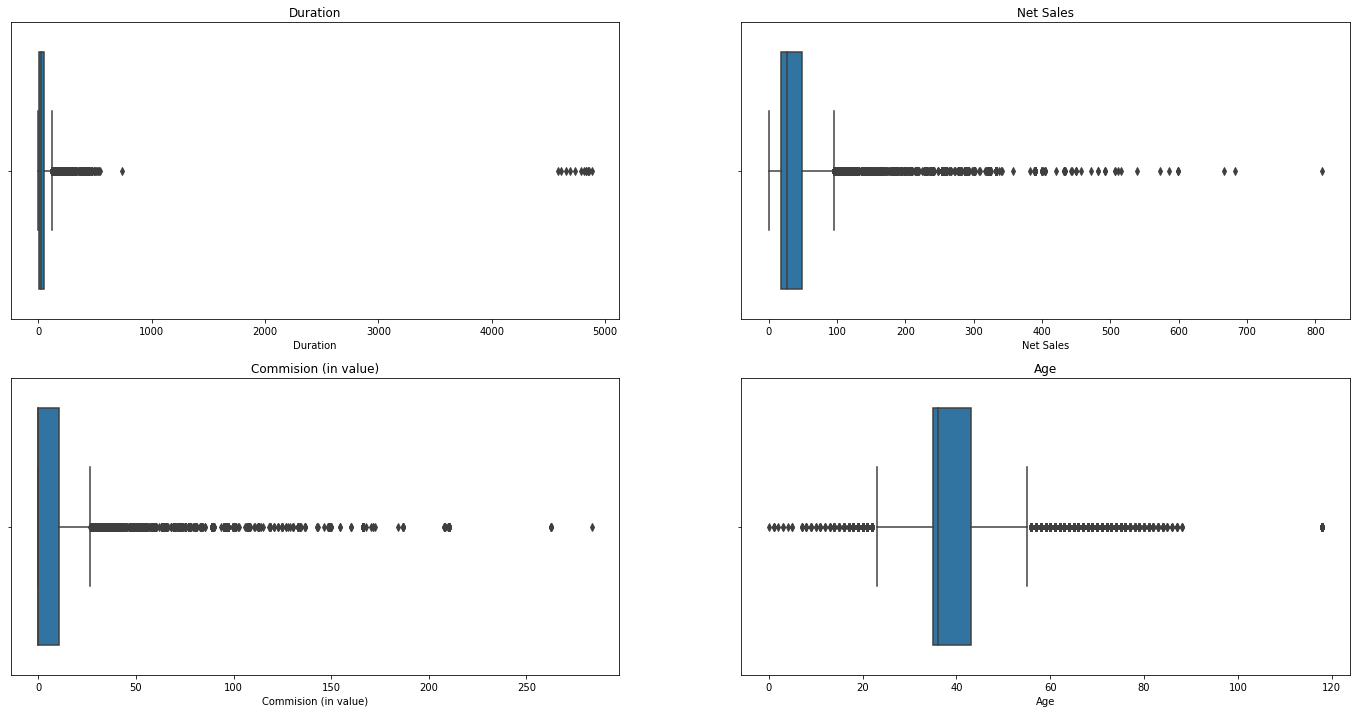

In [17]:
# Menampilkan boxplot kolom numerikal
plot_number = 1
plt.figure(figsize=(24,12))
for kolom in num_features:
    plt.subplot(2,2,plot_number)
    sns.boxplot(data=df, x=kolom)
    plt.title(kolom)
    

    plot_number +=1

Summary boxplot<br>
Dari boxplot dapat terlihat extreme outliers:<br>
    - `Duration` : Durasi perjalanan di atas 4000<br>
    - `Net Sales` : Penjualan di atas 650<br>
    - `Commision (in value)` : Komisi di atas 250<br>
    - `Age`: Usia di atas 100

In [18]:
# Duration > 4000
df[df['Duration'] > 4000]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,SSI,Airlines,Online,Ticket Protector,4736,SINGAPORE,0.32,0.09,48,No
4678,SSI,Airlines,Online,Ticket Protector,4857,SINGAPORE,0.32,0.09,48,No
10172,SSI,Airlines,Online,Ticket Protector,4815,SINGAPORE,0.32,0.09,48,No
12140,SSI,Airlines,Online,Ticket Protector,4652,SINGAPORE,0.32,0.09,48,No
19497,SSI,Airlines,Online,Ticket Protector,4881,SINGAPORE,0.13,0.04,48,No
20038,SSI,Airlines,Online,Ticket Protector,4844,SINGAPORE,0.32,0.09,48,No
22215,SSI,Airlines,Online,Ticket Protector,4580,SINGAPORE,0.32,0.09,48,No
25606,SSI,Airlines,Online,Ticket Protector,4685,SINGAPORE,0.32,0.09,48,No
28032,SSI,Airlines,Online,Ticket Protector,4829,SINGAPORE,0.32,0.09,48,No
37207,SSI,Airlines,Online,Ticket Protector,4609,SINGAPORE,0.32,0.09,48,No


In [19]:
# Rata-rata Duration berdasarkan Agency Type
df.groupby('Agency Type')[['Duration']].mean()

,Duration
Agency Type,
Airlines,68.739016
Travel Agency,41.583231


Outliers `Duration`<br>
Extreme outliers pada kolom `Duration` ini sangat jauh bahkan dari rata-rata berdasarkan `Agency Type`, maka itu data ini akan dihapus agar modeling machine learning pesebaran datanya tidak ada anomali yang sangat jauh dari kumpulan data lainnya.

In [20]:
# Hapus data extreme outliers kolom Duration
df.drop(df[df['Duration'] > 4000].index, inplace=True)

Outliers `Net Sales` and `Commision (in value)`

In [21]:
# Net Sales > 650
df[df['Net Sales'] > 650]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
2810,C2B,Airlines,Online,Annual Gold Plan,364,SINGAPORE,666.0,166.5,31,No
16075,C2B,Airlines,Online,Bronze Plan,179,SINGAPORE,682.0,170.5,25,No
42971,JZI,Airlines,Online,Value Plan,139,UNITED STATES,810.0,283.5,118,No


In [22]:
# Commision (in value) > 250
df[df['Commision (in value)'] > 250]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
10325,LWC,Travel Agency,Online,Annual Travel Protect Platinum,365,UNITED STATES,404.25,262.76,58,No
14556,LWC,Travel Agency,Online,Annual Travel Protect Platinum,378,UNITED STATES,404.25,262.76,45,No
16613,LWC,Travel Agency,Online,Annual Travel Protect Platinum,365,UNITED STATES,404.25,262.76,42,No
23083,LWC,Travel Agency,Online,Annual Travel Protect Platinum,364,UNITED STATES,404.25,262.76,44,No
26407,LWC,Travel Agency,Online,Annual Travel Protect Platinum,371,UNITED STATES,404.25,262.76,38,No
39830,LWC,Travel Agency,Online,Annual Travel Protect Platinum,369,UNITED STATES,404.25,262.76,51,No
42971,JZI,Airlines,Online,Value Plan,139,UNITED STATES,810.00,283.50,118,No


Action due to outliers `Net Sales` and `Commision (in value)`<br>
Karena extreme outliers ini sangat jauh dari kumpulan data lainnya, maka data tersebut akan dihapus

In [23]:
# Menghapus extreme outliers pada kolom Net Sales dan Commision (in value)
df.drop(df[(df['Net Sales'] > 650) | (df['Commision (in value)'] > 250)].index, inplace=True)

Outliers `Age`

In [24]:
claim_100 = pd.DataFrame(df[(df['Age'] > 100)]['Claim'].value_counts()).rename(columns={'Claim' : 'Claim Status (Age > 100)'})
claim_100

,Claim Status (Age > 100)
No,657
Yes,7


Summary outliers `Age`<br>
Terlihat dari usia customer di atas 100 tahun terdapat yang mengajukan `Claim` sebanyak 7, sekarang mari kita lihat bagaimana persentase customer usia di atas 100 tahun yang mengajukan klaim dan tidak terhadap keseluruhan data

In [25]:
total_claim = pd.DataFrame(df['Claim'].value_counts()).rename(columns={'Claim' : 'Total Claim Status'})
claim_percentage = pd.concat([claim_100, total_claim], axis=1)
claim_percentage['percentage'] = ((claim_percentage['Claim Status (Age > 100)'] / claim_percentage['Total Claim Status'])*100).round(2)
claim_percentage

,Claim Status (Age > 100),Total Claim Status,percentage
No,657,43144,1.52
Yes,7,677,1.03


Action due to outliers `Age`<br>
Dari dataframe `claim_percentage` yang mendeskripsikan bagaimana persentase status klaim customer yang berusia di atas 100 tahun. Hanya sekitar **1%** dari total data, maka data tersebut akan dihapus agar pada proses modeling machine learning tidak terjadi bias / sebaran data tidak terlalu jauh pada kolom `Age`

In [26]:
# Menghapus kolom Age > 100
df.drop(df[(df['Age'] > 100)].index, inplace=True)

## `Destination`
Pada kolom `Destination` terlalu banyak *unique value*, yaitu 138 negara. Saat proses Encoding (Binary Encoder) data maka akan sulit diintrepetasi karena akan membuat kolom menjadi sangat banyak. Oleh karena itu akan disederhanakan menggunakan `converter` menjadi `Continent` dan akan diurutkan berdasarkan banyak data per `Destination`.
Berikut adalah tahapan convert negara menjadi benua.

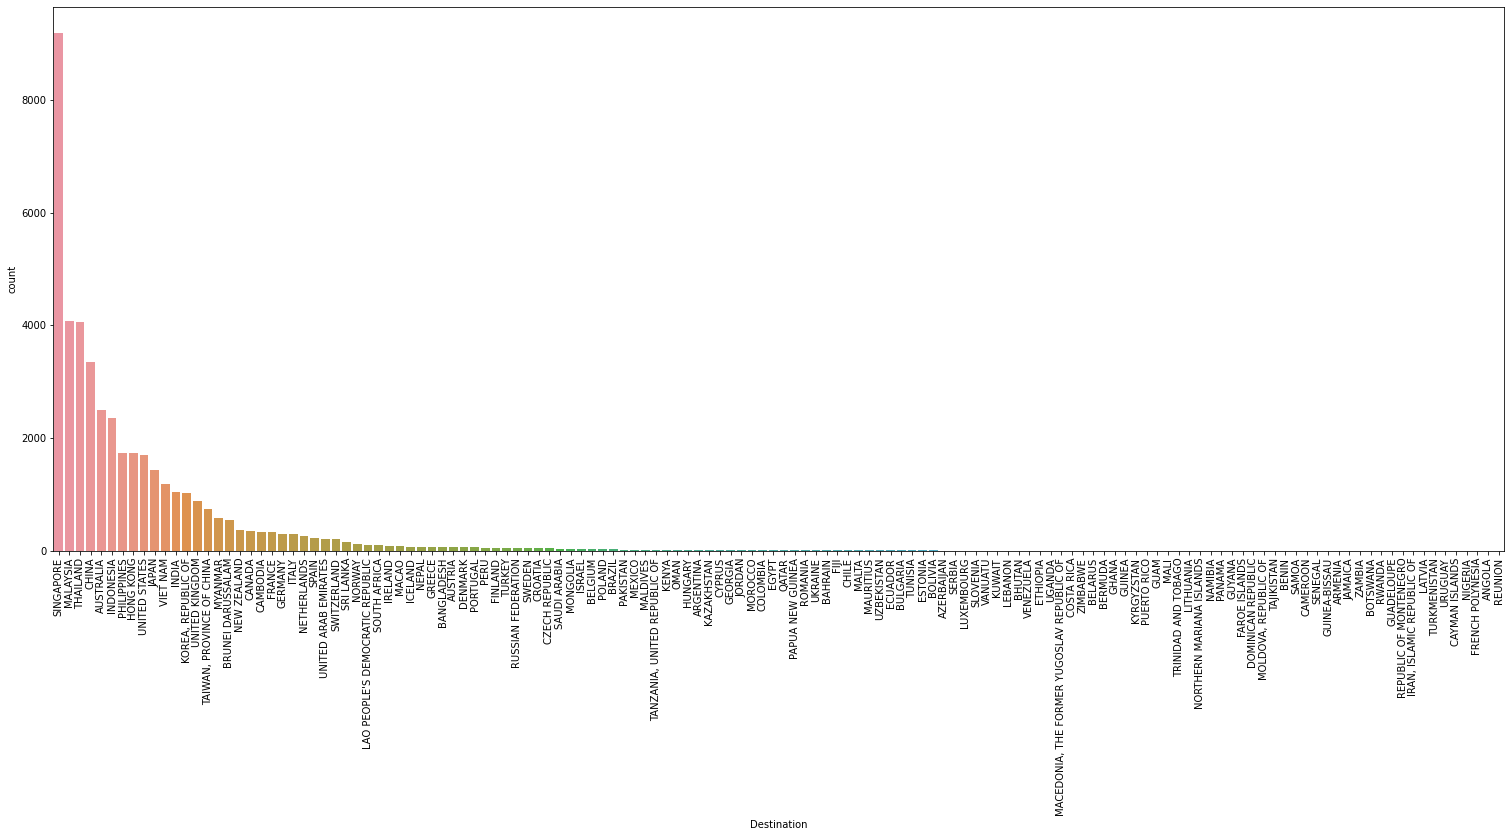

In [27]:
plt.figure(figsize=(26,10))
sns.countplot(data=df, x='Destination', order=df['Destination'].value_counts().index)
plt.xticks(rotation=90);

In [28]:
# Function Converter
cc = coco.CountryConverter()

# Mengubah value negara 'TIBET' menjadi 'CHINA', karena Tibet tidak ada dalam module converter
df.loc[df["Destination"] == "TIBET", "Destination"] = 'CHINA'

# Convert Negara menjadi Continent
continent_list = [cc.convert(names=name, to='Continent') for name in df['Destination']]

In [29]:
# Insert value Continent ke df
df.insert(6, 'Continent', continent_list)
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Continent,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,Asia,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,Asia,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,Asia,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,America,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,Asia,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,Asia,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,Oceania,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,Asia,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,Asia,36.0,0.00,36,No


In [30]:
# Mengurutkan rank jumlah Destination 
count_destination = df.groupby(['Continent','Destination']).count()[['Agency']].sort_values('Agency', ascending=False).reset_index()

# Menambahkan kolom Cummulative Percentage
count_destination['Cummulative Percentage'] = ((count_destination['Agency'] / len(df)) * 100).cumsum(axis = 0).round(2)

# Menampilkan data yang sudah diurutkan
count_destination.rename(columns={'Agency' : 'Count'}).head(20)

,Continent,Destination,Count,Cummulative Percentage
0,Asia,SINGAPORE,9190,21.29
1,Asia,MALAYSIA,4082,30.75
2,Asia,THAILAND,4066,40.17
3,Asia,CHINA,3358,47.96
4,Oceania,AUSTRALIA,2494,53.73
5,Asia,INDONESIA,2365,59.21
6,Asia,PHILIPPINES,1738,63.24
7,Asia,HONG KONG,1728,67.25
8,America,UNITED STATES,1701,71.19
9,Asia,JAPAN,1429,74.50


Dari dataframe akan disimpulkan untuk mengambil data berdasarkan `Cummulative Percentage` sebanyak **85%**, yaitu data sampai ke 14 (TAIWAN). Artinya, sekitar 15% data `Destination`-nya diubah menjadi `OTHER`.

In [31]:
# Membuat list yang berisi Destination rank di atas 14
list_other = (count_destination.iloc[15:]['Destination']).to_list()

# Mengubah Destination di list_other menjadi OTHER
df['Destination'] = df['Destination'].replace(list_other, 'OTHER')
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Continent,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,Asia,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,Asia,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,Asia,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,America,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,Asia,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,Asia,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,Oceania,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,Asia,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,Asia,36.0,0.00,36,No


Setelah disedernakan dengan cara mengubah Destination rank di bawah 14 menjadi OTHER, berikut hasil dari operasi di atas

In [32]:
# Mengurutkan rank jumlah Destination 
count_destination = df.groupby(['Continent','Destination']).count()[['Agency']].sort_values('Agency', ascending=False).reset_index()

# Menambahkan kolom Cummulative Percentage
count_destination['Cummulative Percentage'] = ((count_destination['Agency'] / len(df)) * 100).cumsum(axis = 0).round(2)

# Menampilkan data yang sudah diurutkan
count_destination.rename(columns={'Agency' : 'Count'})

,Continent,Destination,Count,Cummulative Percentage
0,Asia,SINGAPORE,9190,21.29
1,Asia,MALAYSIA,4082,30.75
2,Asia,THAILAND,4066,40.17
3,Asia,CHINA,3358,47.96
4,Europe,OTHER,2537,53.83
5,Oceania,AUSTRALIA,2494,59.61
6,Asia,OTHER,2468,65.33
7,Asia,INDONESIA,2365,70.81
8,Asia,PHILIPPINES,1738,74.84
9,Asia,HONG KONG,1728,78.84


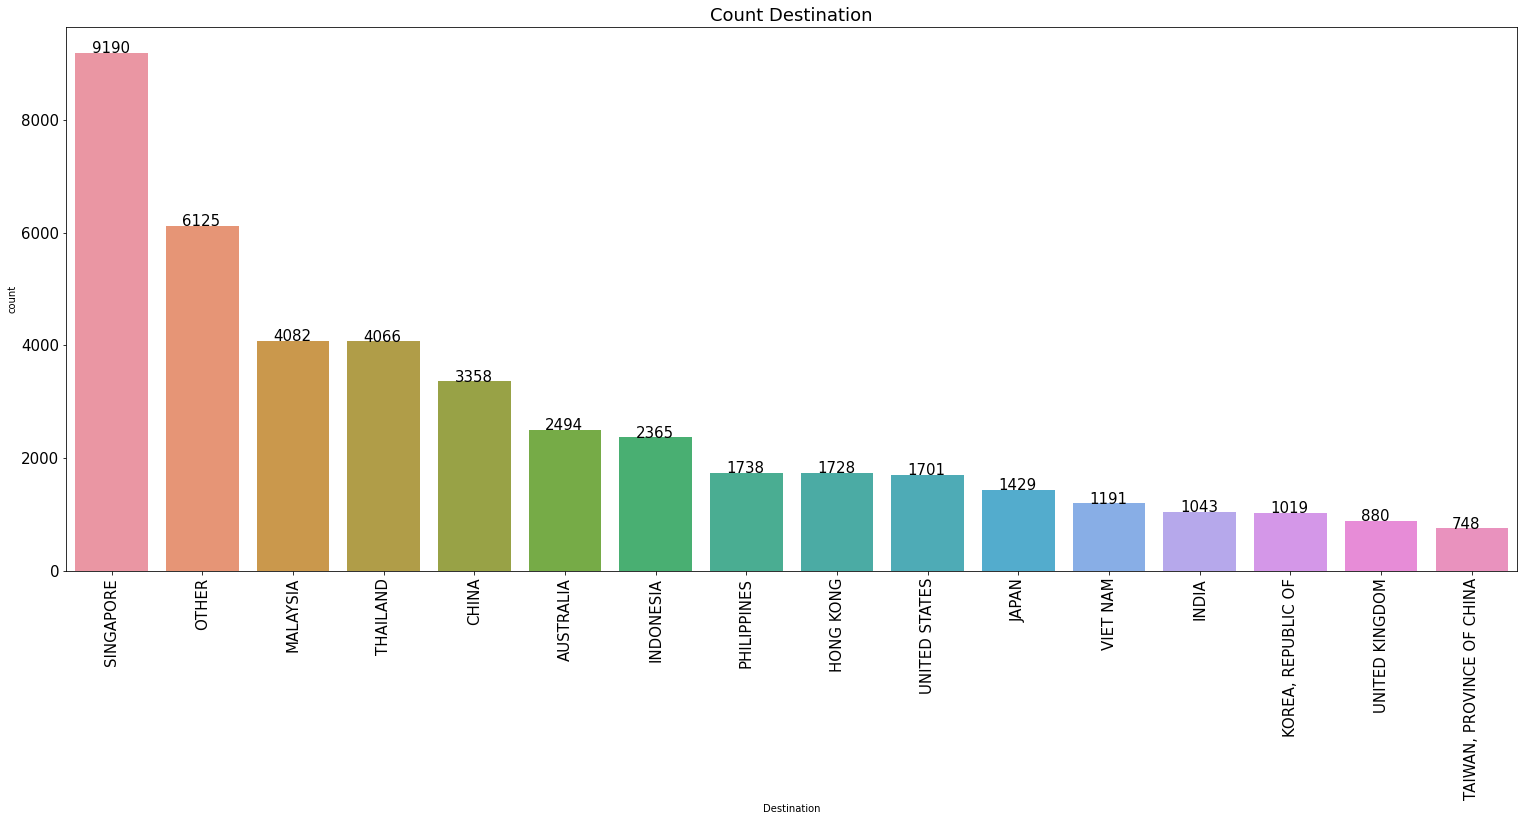

In [33]:
plt.figure(figsize=(26,10))
ax = sns.countplot(data=df, x='Destination', order=df['Destination'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.18, p.get_height()+0.1), fontsize=15)

plt.title('Count Destination', fontsize=18)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

plt.xticks(rotation=90);

## `Claim`
Mengubah value dari `Claim`
- 0 : No
- 1 : Yes

In [34]:
df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)

Berikut ini adalah presentase data customer yang mengajukan klaim asuransi perjalanan.

In [35]:
df_claim = pd.DataFrame(df['Claim'].value_counts())
df_claim

,Claim
0,42487
1,670


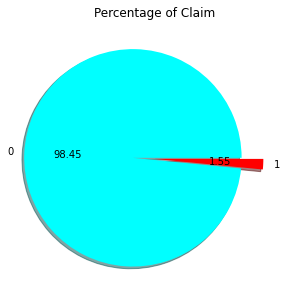

In [36]:
plt.figure(figsize=(5,5))
plt.pie(
    x = df_claim['Claim'],
    labels = df_claim.index,
    autopct = f'%.2f',
    explode = (0.2,0),
    shadow=True,
    colors=('cyan', 'red')
)

plt.title('Percentage of Claim')

plt.show()

Terlihat dari pie chart di atas, merupakan persentase yang **moderate imbalance (1% - 20%)**. Karena itu perlu dilakukan *imbalance treatment* pada saat preprocessing atau modeling machine learning.

## `Summary Data Cleaning`
Setelah selesai proses data cleaning, berikut adalah ringkasan dari data akhir yang akan selanjutnya ke proses machine learning

In [37]:
# Menampilkan ringkasan data cleaning
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(43157, 11)


,dataFeatures,dataType,null,unique,uniqueSample
0,Agency,object,0,15,"[CSR, SSI]"
1,Agency Type,object,0,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,2,"[Online, Offline]"
3,Product Name,object,0,26,"[Annual Travel Protect Silver, Cancellation Plan]"
4,Duration,int64,0,422,"[190, 13]"
5,Destination,object,0,16,"[THAILAND, INDONESIA]"
6,Continent,object,0,5,"[Africa, Oceania]"
7,Net Sales,float64,0,866,"[44.5, 4.68]"
8,Commision (in value),float64,0,880,"[6.85, 21.5]"
9,Age,int64,0,88,"[47, 40]"


# `EDA`

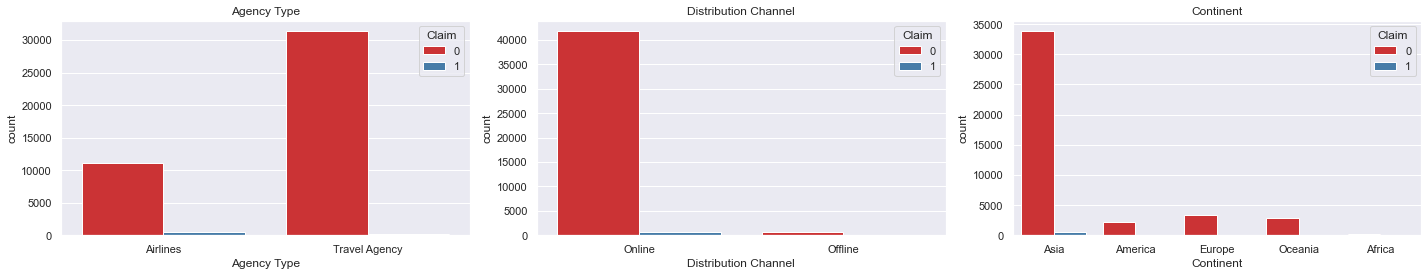

In [38]:
# Jumlah customer untuk tiap categorical variables berdasarkan Claim
features = ['Agency Type', 'Distribution Channel', 'Continent']
plt.figure(figsize=(20, 4))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, len(features), plotnumber)
    sns.countplot(x=feature, hue='Claim', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

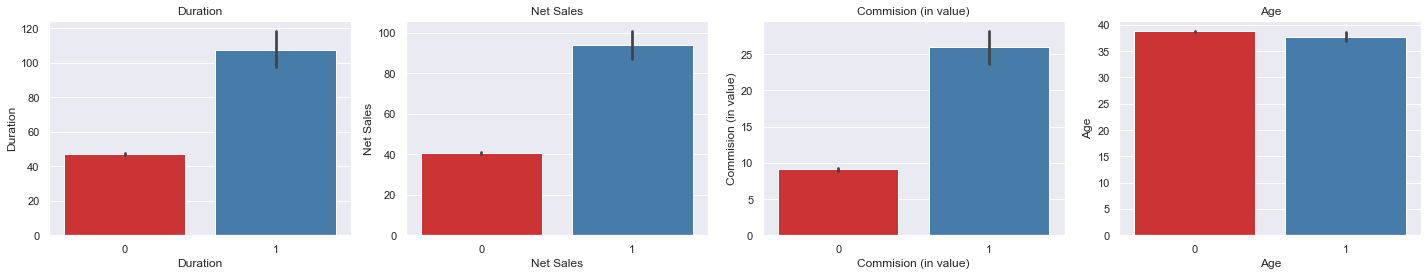

In [39]:
# Rata-rata customer untuk tiap numerikal variables berdasarkan Claim

plt.figure(figsize=(20, 4))
plotnumber = 1

for feat in num_features:
    ax = plt.subplot(1, len(num_features), plotnumber)
    sns.barplot(x='Claim', y=feat, data=df)
    plt.xlabel(feat)
    plt.title(feat)
    plotnumber += 1
    plt.tight_layout();

# `DATA SPLITTING`

## `Define X y`

In [40]:
X = df.drop(columns='Claim')
y = df['Claim']

## `Splitting`

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [42]:
# Kolom kategorikal
cat_features = [feature for feature in X_train.columns if (X_train[feature].dtypes == 'O')]
cat_features

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Destination',
 'Continent']

In [43]:
# Menampilkan jumlah unique value pada tiap kolom kategorikal 
listItem = []
for col in cat_features:
    listItem.append([col, X_train[col].nunique(),  X_test[col].nunique()])

X_uniqueDesc = pd.DataFrame(columns=['dataFeatures', 'X_train', 'X_test'], data=listItem)
print(X_train.shape)
X_uniqueDesc

(34525, 10)


,dataFeatures,X_train,X_test
0,Agency,15,15
1,Agency Type,2,2
2,Distribution Channel,2,2
3,Product Name,26,24
4,Destination,16,16
5,Continent,5,5


Dengan menggunakan random_state = 0, maka dapat terlihat pada kolom `Product Name` X_train ada 26 sedangkan pada kolom X_test ada 24. Ini karena pada saat proses splitting tidak merata pada kolom `Product Name`, X_train mempelajari lebih banyak unique value daripada X_test. Ini menyebabkan selisih unique value yang dipelajari tidak akan dibuktikan pada proses test.
Karena ini kita akan mencoba mengganti parameter random_state agar menjadi seimbang

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [45]:
# Menampilkan jumlah unique value pada tiap kolom kategorikal 
listItem = []
for col in cat_features:
    listItem.append([col, X_train[col].nunique(),  X_test[col].nunique()])

X_uniqueDesc = pd.DataFrame(columns=['dataFeatures', 'X_train', 'X_test'], data=listItem)
print(X_train.shape)
X_uniqueDesc

(34525, 10)


,dataFeatures,X_train,X_test
0,Agency,15,15
1,Agency Type,2,2
2,Distribution Channel,2,2
3,Product Name,25,25
4,Destination,16,16
5,Continent,5,5


Menggunakan random_state = 1, maka unique value pada tiap kolom kategorikal menjadi seimbang

# **`PREPROCESSING`**

Pertama-tama akan membuat encoding dan scaling pada tiap kolom.
- Encoding:
    - One Hot Encoder:
    Kolom kategorikal pada dataset ini menggunakan One Hot Encoder karena data bukan berupa urutan (ordinal) dan jumlah unique value tergolong sedikit,meskipun `Product Name` dan `Agency` cukup banyak namun masih bisa diinterpretasikan menggunakan One Hot Encoder
        - `Agency`
        - `Agency Type`
        - `Distribution Channel`
        - `Product Name`
        - `Destination`
        - `Continent`

- Scaling:
    - Robust Scaler:
    Kolom numerikal pada dataset ini menggunakan Robust Scaler karena mayoritas data tidak terdistribusi normal, Robust Scaler digunakan cocok untuk data yang memiliki outliers agar semua median dijadikan 0.
        - `Duration`
        - `Net Sales`
        - `Commision (in value)`
        - `Age`


In [46]:
# Product Name yang tidak ada pada data train_set namun ada pada data test_set
for product_name in X_test['Product Name'].unique():
    if product_name not in X_train['Product Name'].unique():
        print(product_name)

# Untuk mengatasi bias ini maka dalam transform encoding diberikan parameter `handle_unknown`. Hasil target dari test ini akan dianggap 0

Travel Cruise Protect Family


In [47]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Continent', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

In [234]:
# Transformer
transformer_no_poly = ColumnTransformer([
    ('scaling', RobustScaler(), ['Age', 'Duration', 'Net Sales', 'Commision (in value)']),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'Continent'])
],  remainder='passthrough')

In [266]:
# Pipeline
pipe_poly = Pipeline([
    ('scaling', RobustScaler() ),
    ('poly', PolynomialFeatures(degree=2))
])

# Transformer
transformer_poly = ColumnTransformer([
    ('pipe_poly', pipe_poly, ['Age','Duration', 'Net Sales', 'Commision (in value)']),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'Continent'])
],  remainder='passthrough')

In [267]:
# Hasil transformer dalam bentuk DataFrame
hasil_transformer = pd.DataFrame(transformer_poly.fit_transform(X_train),columns=transformer_poly.get_feature_names_out())
hasil_transformer.head()

,pipe_poly__1,pipe_poly__Age,pipe_poly__Duration,pipe_poly__Net Sales,pipe_poly__Commision (in value),pipe_poly__Age^2,pipe_poly__Age Duration,pipe_poly__Age Net Sales,pipe_poly__Age Commision (in value),pipe_poly__Duration^2,...,onehot__Destination_SINGAPORE,"onehot__Destination_TAIWAN, PROVINCE OF CHINA",onehot__Destination_THAILAND,onehot__Destination_UNITED KINGDOM,onehot__Destination_UNITED STATES,onehot__Destination_VIET NAM,onehot__Continent_America,onehot__Continent_Asia,onehot__Continent_Europe,onehot__Continent_Oceania
0,1.0,1.714286,0.860465,-0.562333,0.243810,2.938776,1.475083,-0.96400,0.417959,0.740400,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.000000,0.279070,1.300000,0.000000,0.000000,0.000000,0.00000,0.000000,0.077880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.000000,-0.325581,-0.366667,0.000000,0.000000,-0.000000,-0.00000,0.000000,0.106003,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,-0.142857,0.232558,-0.866667,4.525714,0.020408,-0.033223,0.12381,-0.646531,0.054083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.000000,-0.209302,0.066667,0.000000,0.000000,-0.000000,0.00000,0.000000,0.043807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# **`MODELING & EVALUATION`**

In [51]:
f2_score = make_scorer(fbeta_score, beta=2)

In [52]:
# 3 base model (Basic ML algorithm)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, max_depth=5)

# Ensemble Similar Type
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)

# Ensemble Various Type
voting_clf = VotingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

# Ensemble 
stacking_clf = StackingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

## `Model Benchmark (Without Balancing)`

In [541]:
# cross validation

list_model = [logreg, knn, tree, rf, adaboost, gboost, voting_clf, stacking_clf]
list_all = []
list_mean = []
list_std = []

for model in list_model:

    pipe_model = Pipeline([
        ('prep', transformer_no_poly),
        ('model', model)
    ])
    skfold = StratifiedKFold(n_splits=5)


    model_cv = cross_val_score(
        estimator= pipe_model,
        X= X_train,
        y= y_train,
        scoring=f2_score,
        cv= skfold,
        n_jobs=-1
    )

    list_all.append(model_cv.round(4))
    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())



# Running time : 4 minutes

In [542]:
df_score = pd.DataFrame({
    'algo': list_model,
    'mean': list_mean,
    'std': list_std,
    'all_score': list_all
})

df_score

,algo,mean,std,all_score
0,LogisticRegression(random_state=0),0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]"
1,KNeighborsClassifier(),0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]"
2,"DecisionTreeClassifier(max_depth=5, random_sta...",0.002299,0.004598,"[0.0, 0.0115, 0.0, 0.0, 0.0]"
3,RandomForestClassifier(random_state=0),0.031032,0.025457,"[0.0, 0.011, 0.0556, 0.0228, 0.0658]"
4,AdaBoostClassifier(random_state=0),0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]"
5,GradientBoostingClassifier(random_state=0),0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]"
6,"VotingClassifier(estimators=[('clf1', Logistic...",0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]"
7,"StackingClassifier(estimators=[('clf1', Logist...",0.004619,0.005657,"[0.0, 0.0115, 0.0116, 0.0, 0.0]"


Hasil dari cross_validation masih sangat rendah prediksinya, ini disebabkan oleh imbalance dataset yang ada. Oleh karena itu diperlukan imbalance treatment untuk mengatasi kasus ini.

## `Model Benchmark (With Balancing Treatment)`

In [55]:
# Balancing Treatment
smote = SMOTE(random_state=0)
nearmiss = NearMiss()
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)

### `Without Polynomial Features`

In [235]:
# cross validation

list_model = [logreg, knn, tree, rf, adaboost, gboost, voting_clf, stacking_clf]
list_balancing = [smote, nearmiss, ros, rus]
list_all = []
list_mean = []
list_std = []

for model in list_model:

    skfold = StratifiedKFold(n_splits=5)
    
    for balancing in list_balancing:
        pipe_model = Pipeline([
            ('prep', transformer_no_poly),
            ('balancing', balancing),
            ('model', model)
        ])

        model_cv = cross_val_score(
            estimator= pipe_model,
            X= X_train,
            y= y_train,
            scoring=f2_score,
            cv= skfold,
            n_jobs=-1
        )

        list_all.append(model_cv.round(4))
        list_mean.append(model_cv.mean())
        list_std.append(model_cv.std())



# Running time : 15 minutes

In [236]:
list_model_name = []
list_balancing_name = []
for model in list_model:
    for balancing in list_balancing:
        
        list_model_name.append(model)
        list_balancing_name.append(balancing)

        
df_score_balancing_no_poly = pd.DataFrame({
    'algo': list_model_name,
    'balancing' : list_balancing_name,
    'mean': list_mean,
    'std': list_std,
    'all_score': list_all
})

df_score_balancing_no_poly.sort_values('mean', ascending=False).head(5)

,algo,balancing,mean,std,all_score
26,"VotingClassifier(estimators=[('clf1', Logistic...",RandomOverSampler(random_state=0),0.246803,0.010931,"[0.2608, 0.2431, 0.2513, 0.2507, 0.228]"
20,GradientBoostingClassifier(random_state=0),SMOTE(random_state=0),0.243106,0.016208,"[0.2637, 0.2313, 0.2594, 0.2397, 0.2214]"
10,"DecisionTreeClassifier(max_depth=5, random_sta...",RandomOverSampler(random_state=0),0.235871,0.010500,"[0.2397, 0.2353, 0.2361, 0.2504, 0.2178]"
24,"VotingClassifier(estimators=[('clf1', Logistic...",SMOTE(random_state=0),0.227340,0.024845,"[0.2044, 0.2249, 0.27, 0.2359, 0.2016]"
16,AdaBoostClassifier(random_state=0),SMOTE(random_state=0),0.224770,0.014143,"[0.2366, 0.2273, 0.2185, 0.2405, 0.201]"


### `With Polynomial Features`

In [56]:
# cross validation

list_model = [logreg, knn, tree, rf, adaboost, gboost, voting_clf, stacking_clf]
list_balancing = [smote, nearmiss, ros, rus]
list_all = []
list_mean = []
list_std = []

for model in list_model:

    skfold = StratifiedKFold(n_splits=5)
    
    for balancing in list_balancing:
        pipe_model = Pipeline([
            ('prep', transformer_poly),
            ('balancing', balancing),
            ('model', model)
        ])

        model_cv = cross_val_score(
            estimator= pipe_model,
            X= X_train,
            y= y_train,
            scoring=f2_score,
            cv= skfold,
            n_jobs=-1
        )

        list_all.append(model_cv.round(4))
        list_mean.append(model_cv.mean())
        list_std.append(model_cv.std())



# Running time : 23 minutes

In [57]:
list_model_name = []
list_balancing_name = []
for model in list_model:
    for balancing in list_balancing:
        
        list_model_name.append(model)
        list_balancing_name.append(balancing)

        
df_score_balancing = pd.DataFrame({
    'algo': list_model_name,
    'balancing' : list_balancing_name,
    'mean': list_mean,
    'std': list_std,
    'all_score': list_all
})

df_score_balancing.sort_values('mean', ascending=False).head(5)

,algo,balancing,mean,std,all_score
20,GradientBoostingClassifier(random_state=0),SMOTE(random_state=0),0.256669,0.017711,"[0.2651, 0.2405, 0.269, 0.2775, 0.2312]"
16,AdaBoostClassifier(random_state=0),SMOTE(random_state=0),0.246023,0.016163,"[0.2568, 0.2209, 0.254, 0.2646, 0.2339]"
26,"VotingClassifier(estimators=[('clf1', Logistic...",RandomOverSampler(random_state=0),0.238471,0.011727,"[0.2557, 0.2437, 0.2335, 0.2393, 0.2201]"
24,"VotingClassifier(estimators=[('clf1', Logistic...",SMOTE(random_state=0),0.229943,0.018052,"[0.2248, 0.2309, 0.2475, 0.2478, 0.1987]"
22,GradientBoostingClassifier(random_state=0),RandomOverSampler(random_state=0),0.229633,0.007182,"[0.2269, 0.2347, 0.2332, 0.2365, 0.2168]"


### Summary Benchmark

Dari 2 hasil cross validation di atas (menggunakan dan tidak menggunakan Polynomial Features) tidak berbeda signifikan yaitu hanya sekitar 1%. Dengan mempertimbangkan kemungkinan terjadinya Overfitting (resiko yang diberikan tidak sebanding dengan peningkatan performa), maka pada kasus ini asumsi yang akan dipilih tidak menggunakan Polynomial Features. Namun pada Hyperparameter Tuning di bawah ini akan dilihat mana yang lebih baik.

**Algoritma yang digunakan : Voting Classifier <br>
Balancing yang digunakan : Random Over Sampler**

## `Hyperparameter Tuning`

In [300]:
# Create the algorithm chains

def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter):
# model
    model = voting_clf
    balancing = ros

    pipe_model = Pipeline([
    ('prep', transformer),
    ('balancing', balancing),
    ('model', model)
    ])

# Stratified cross validation
    skf = StratifiedKFold(n_splits = 5)

    if searchCV == 'random_search' :

    # Hyperparameter tuning
        random_search = RandomizedSearchCV(
        estimator = pipe_model,
        param_distributions= hyperparameters,
        cv = skf, 
        scoring = metric, 
        n_jobs = -1,
        random_state=0,
        n_iter=n_iter
        )

        fit = random_search.fit(X_train, y_train)
        best_score = random_search.best_score_
        best_estimator = random_search.best_estimator_
        best_params = random_search.best_params_

        return fit, best_score, best_estimator, best_params
         

    elif searchCV == 'grid_search' :

    # Hyperparameter tuning
        grid_search = GridSearchCV(
            estimator = pipe_model,
            param_grid = hyperparameters, 
            cv = skf, 
            scoring = metric, 
            n_jobs = -1,
        )
        
        fit = grid_search.fit(X_train, y_train)
        best_score = grid_search.best_score_
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_

        return fit, best_score, best_estimator, best_params
        


### `Without Polynomial Features`

In [257]:
# Hyperparameter space
hyperparam_space_no_poly = {
    'prep__scaling': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model__clf1__C': [100,10,1,0.01,0.001],       
    'model__clf1__solver' : ['liblinear', 'sag'], 
    'model__clf2__n_neighbors': range(2,30,2),
    'model__clf2__metric' : ['manhattan', 'minkowski'],      
    'model__clf3__max_depth': range(2,30,2),        
    'model__clf3__min_samples_leaf': range(2,30,2)
}

#### `Randomized Search`

In [258]:
# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

random_search_f2_no_poly = hyperparameter_tuning(transformer_no_poly, f2_score, hyperparam_space_no_poly, 'random_search', 100)

# Running time : 85 minutes

#### `Grid Search`

In [261]:
random_search_f2_no_poly[-1]

{'prep__scaling': MinMaxScaler(),
 'model__clf3__min_samples_leaf': 28,
 'model__clf3__max_depth': 4,
 'model__clf2__n_neighbors': 2,
 'model__clf2__metric': 'minkowski',
 'model__clf1__solver': 'sag',
 'model__clf1__C': 100}

In [262]:
# Hyperparameter space
hyperparam_space_no_poly = {
    'prep__scaling': [MinMaxScaler()],
    'model__clf1__C': [100,10],       
    'model__clf1__solver' : ['sag'], 
    'model__clf2__n_neighbors': range(2,7,2),
    'model__clf2__metric' : ['minkowski'],      
    'model__clf3__max_depth': range(2,7,2),        
    'model__clf3__min_samples_leaf': range(24,30,2)
}

# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

grid_search_f2_no_poly = hyperparameter_tuning(transformer_no_poly, f2_score, hyperparam_space_no_poly, 'grid_search', 0)

# Running time : 32 minutes

### `With Polynomial Features`

#### `Randomized Search`

In [301]:
# Hyperparameter space
hyperparam_space_poly = {
    'prep__scaling': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model__clf1__C': [100,10,1,0.01,0.001],       
    'model__clf1__solver' : ['liblinear', 'sag'], 
    'model__clf2__n_neighbors': range(2,30,2),
    'model__clf2__metric' : ['manhattan', 'minkowski'],      
    'model__clf3__max_depth': range(2,30,2),        
    'model__clf3__min_samples_leaf': range(2,30,2)
}

In [269]:
# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

random_search_f2_poly = hyperparameter_tuning(transformer_poly, f2_score, hyperparam_space_poly, 'random_search', 100)

# Running time : 102 minutes

#### `Grid Search`

In [273]:
random_search_f2_poly[3]

{'prep__pipe_poly__scaling': StandardScaler(),
 'model__clf3__min_samples_leaf': 26,
 'model__clf3__max_depth': 2,
 'model__clf2__n_neighbors': 4,
 'model__clf2__metric': 'manhattan',
 'model__clf1__solver': 'sag',
 'model__clf1__C': 100}

In [275]:
# Hyperparameter space
hyperparam_space_poly = {
    'prep__pipe_poly__scaling': [StandardScaler()],
    'model__clf1__C': [100,10],       
    'model__clf1__solver' : ['sag'], 
    'model__clf2__n_neighbors': range(2,7,2),
    'model__clf2__metric' : ['manhattan'],      
    'model__clf3__max_depth': range(2,7,2),        
    'model__clf3__min_samples_leaf': range(24,30,2)
}

# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

grid_search_f2_poly = hyperparameter_tuning(transformer_poly, f2_score, hyperparam_space_poly, 'grid_search', 0)

# Running time : 87 minutes

### `Summary Hyperparameter Tuning`

In [299]:
tuning_summary = pd.DataFrame({
    'Polynomial' : ['No Polynomial', 'With Polynomial'],
    'f2_score' : [grid_search_f2_no_poly[1], grid_search_f2_poly[1]],
    'Scaling' : [grid_search_f2_no_poly[-1]['prep__scaling'] , grid_search_f2_poly[-1]['prep__pipe_poly__scaling']],
    'LogReg_C' : [grid_search_f2_no_poly[-1]['model__clf1__C'] , grid_search_f2_poly[-1]['model__clf1__C']],
    'LogReg_solver' : [grid_search_f2_no_poly[-1]['model__clf1__solver'] , grid_search_f2_poly[-1]['model__clf1__solver']],

    'KNN_metric' : [grid_search_f2_no_poly[-1]['model__clf2__metric'] , grid_search_f2_poly[-1]['model__clf2__metric']],
    'KNN_n_neighbors' : [grid_search_f2_no_poly[-1]['model__clf2__n_neighbors'] , grid_search_f2_poly[-1]['model__clf2__n_neighbors']],

    'Tree_max_depth' : [grid_search_f2_no_poly[-1]['model__clf3__max_depth'] , grid_search_f2_poly[-1]['model__clf3__max_depth']],
    'Tree_min_samples_leaf' : [grid_search_f2_no_poly[-1]['model__clf3__min_samples_leaf'] , grid_search_f2_poly[-1]['model__clf3__min_samples_leaf']]
})
tuning_summary

,Polynomial,f2_score,Scaling,LogReg_C,LogReg_solver,KNN_metric,KNN_n_neighbors,Tree_max_depth,Tree_min_samples_leaf
0,No Polynomial,0.251917,MinMaxScaler(),10,sag,minkowski,2,4,24
1,With Polynomial,0.250411,StandardScaler(),100,sag,manhattan,2,2,24


## `Hyperparameter Tuning for Other Metrics`

#### `f1_score`

In [312]:
# Hyperparameter space for RandomizedSearch
hyperparam_space_random = {
    'prep__scaling': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'model__clf1__C': [100,10,1,0.01,0.001],       
    'model__clf1__solver' : ['liblinear', 'sag'], 
    'model__clf2__n_neighbors': range(2,30,2),
    'model__clf2__metric' : ['manhattan', 'minkowski'],      
    'model__clf3__max_depth': range(2,30,2),        
    'model__clf3__min_samples_leaf': range(2,30,2)
}

In [315]:
# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

random_search_f1 = hyperparameter_tuning(transformer_no_poly, 'f1', hyperparam_space_random, 'random_search', 50)

# Running time : 48 minutes

In [320]:
random_search_f1[-1]

{'prep__scaling': StandardScaler(),
 'model__clf3__min_samples_leaf': 10,
 'model__clf3__max_depth': 4,
 'model__clf2__n_neighbors': 6,
 'model__clf2__metric': 'manhattan',
 'model__clf1__solver': 'liblinear',
 'model__clf1__C': 0.001}

In [323]:
# Hyperparameter space for GridSearch
hyperparam_space_grid_f1 = {
    'prep__scaling': [StandardScaler()],
    'model__clf1__C': [0.01,0.001],       
    'model__clf1__solver' : ['liblinear'], 
    'model__clf2__n_neighbors': range(4,9,2),
    'model__clf2__metric' : ['manhattan'],      
    'model__clf3__max_depth': range(2,7,2),        
    'model__clf3__min_samples_leaf': range(8,13,2)
}

# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

grid_search_f1 = hyperparameter_tuning(transformer_no_poly, 'f1', hyperparam_space_grid_f1, 'grid_search', 0)

# Running time : 70 minutes

### `recall_score`

In [317]:
# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

random_search_recall = hyperparameter_tuning(transformer_no_poly, 'recall', hyperparam_space_random, 'random_search', 50)

# Running time : 48 minutes

In [321]:
random_search_recall[-1]

{'prep__scaling': StandardScaler(),
 'model__clf3__min_samples_leaf': 22,
 'model__clf3__max_depth': 2,
 'model__clf2__n_neighbors': 26,
 'model__clf2__metric': 'minkowski',
 'model__clf1__solver': 'sag',
 'model__clf1__C': 1}

In [324]:
# Hyperparameter space for GridSearch
hyperparam_space_grid_recall = {
    'prep__scaling': [StandardScaler()],
    'model__clf1__C': [1,0.01],       
    'model__clf1__solver' : ['sag'], 
    'model__clf2__n_neighbors': range(24,29,2),
    'model__clf2__metric' : ['minkowski'],      
    'model__clf3__max_depth': range(2,7,2),        
    'model__clf3__min_samples_leaf': range(20,25,2)
}

# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

grid_search_recall = hyperparameter_tuning(transformer_no_poly, 'recall', hyperparam_space_grid_recall, 'grid_search', 0)

# Running time : 31 minutes

### `precision_score`

In [319]:
# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

random_search_precision = hyperparameter_tuning(transformer_no_poly, 'precision', hyperparam_space_random, 'random_search', 50)

# Running time : 49 minutes

In [322]:
random_search_precision[-1]

{'prep__scaling': MinMaxScaler(),
 'model__clf3__min_samples_leaf': 14,
 'model__clf3__max_depth': 24,
 'model__clf2__n_neighbors': 6,
 'model__clf2__metric': 'minkowski',
 'model__clf1__solver': 'liblinear',
 'model__clf1__C': 0.01}

In [325]:
# Hyperparameter space for GridSearch
hyperparam_space_grid_precision = {
    'prep__scaling': [MinMaxScaler()],
    'model__clf1__C': [0.01,0.001],       
    'model__clf1__solver' : ['liblinear'], 
    'model__clf2__n_neighbors': range(4,9,2),
    'model__clf2__metric' : ['minkowski'],      
    'model__clf3__max_depth': range(22,27,2),        
    'model__clf3__min_samples_leaf': range(12,17,2)
}

# def hyperparameter_tuning(transformer, metric, hyperparameters, searchCV, n_iter)
# return fit, best_score, best_estimator, best_params

grid_search_precision = hyperparameter_tuning(transformer_no_poly, 'precision', hyperparam_space_grid_precision, 'grid_search', 0)

# Running time : 26 minutes

### `Summary`

In [335]:
metric_tuning_summary = pd.DataFrame({
    'Metric' : ['f1_score', 'recall_score', 'precision_score'],
    'train_best_score' : [grid_search_f1[1], grid_search_recall[1], grid_search_precision[1]],
})
metric_tuning_summary

,Metric,train_best_score
0,f1_score,0.131456
1,recall_score,0.682918
2,precision_score,0.085186


## `Predict to Test Set`

### `Metric Utama (f2_score)`

#### `Without Polynomial Features`

##### `Before Tuning`

In [328]:
# define model
model = voting_clf
balancing = ros
pipe_model = Pipeline([
    ('prep',transformer_no_poly),
    ('balancing', balancing),
    ('model', model)          
])

# fitting
pipe_model.fit(X_train, y_train)

# predict
y_pred_benchmark_f2 = pipe_model.predict(X_test)
fbeta_score(y_test, y_pred_benchmark_f2, beta=2)


0.2097018696311268

##### `After Tuning`

In [329]:
# menggunakan model terbaik hasil grid_search
model = grid_search_f2_no_poly[2]
model.fit(X_train, y_train)

y_pred_gridsearch_f2 = model.predict(X_test)
fbeta_score(y_test, y_pred_gridsearch_f2, beta=2)

0.22605591909577633

In [330]:
print(classification_report(y_test, y_pred_gridsearch_f2))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      8498
           1       0.07      0.57      0.12       134

    accuracy                           0.87      8632
   macro avg       0.53      0.72      0.52      8632
weighted avg       0.98      0.87      0.92      8632



In [343]:
confusion_matrix(y_test, y_pred_gridsearch_f2)

array([[7429, 1069],
       [  58,   76]], dtype=int64)

#### `With Polynomial Features`

##### `Before Tuning`

In [344]:
# define model
model = voting_clf
balancing = ros
pipe_model = Pipeline([
    ('prep',transformer_poly),
    ('balancing', balancing),
    ('model', model)          
])

# fitting
pipe_model.fit(X_train, y_train)

# predict
y_pred_benchmark_f2_poly = pipe_model.predict(X_test)
fbeta_score(y_test, y_pred_benchmark_f2_poly, beta=2)


0.20907700152983172

##### `After Tuning`

In [340]:
# menggunakan model terbaik hasil grid_search
model = grid_search_f2_poly[2]
model.fit(X_train, y_train)

y_pred_gridsearch_f2_poly = model.predict(X_test)
fbeta_score(y_test, y_pred_gridsearch_f2_poly, beta=2)

0.22401433691756273

#### `Comparison Before and After Tuning`

Before dan After Tuning dengan menggunakan dan tidak menggunakan Polynomial Features, keduanya berhasil meningkatkan performa setelah dilakukan Hyperparameter Tuning. Namun untuk perbandingan selanjutnya akan melibatkan tanpa menggunakan Polynomial Features karena tidak mempengaruhi secara signifikan jika menggunakan Polynomial Features.

### `After Tuning with Other Metrics`

#### `f1_score`

In [332]:
# menggunakan model terbaik hasil grid_search
model = grid_search_f1[2]
model.fit(X_train, y_train)

y_pred_gridsearch_f1 = model.predict(X_test)
f1_score(y_test, y_pred_gridsearch_f1)

0.12273800157356413

#### `recall_score`

In [333]:
# menggunakan model terbaik hasil grid_search
model = grid_search_recall[2]
model.fit(X_train, y_train)

y_pred_gridsearch_recall = model.predict(X_test)
recall_score(y_test, y_pred_gridsearch_recall)

0.6119402985074627

#### `precision_score`

In [334]:
# menggunakan model terbaik hasil grid_search
model = grid_search_precision[2]
model.fit(X_train, y_train)

y_pred_gridsearch_precision = model.predict(X_test)
precision_score(y_test, y_pred_gridsearch_precision)

0.06273764258555133

### `Score Summary`

In [345]:
test_score = pd.DataFrame({
    'Metric' : ['f2_score_no_poly', 'f1_score', 'recall_score', 'precision_score'],
    'train_best_score' : [grid_search_f2_no_poly[1], grid_search_f1[1], grid_search_recall[1], grid_search_precision[1]],
    'test_best_score' : [fbeta_score(y_test, y_pred_gridsearch_f2, beta=2), f1_score(y_test, y_pred_gridsearch_f1), recall_score(y_test, y_pred_gridsearch_recall), precision_score(y_test, y_pred_gridsearch_precision)],
})
test_score

,Metric,train_best_score,test_best_score
0,f2_score_no_poly,0.251917,0.226056
1,f1_score,0.131456,0.122738
2,recall_score,0.682918,0.611940
3,precision_score,0.085186,0.062738


In [491]:
# Metric Final
model = grid_search_precision[2]
model.fit(X_train, y_train)

y_pred_gridsearch_precision = model.predict(X_test)
precision_score(y_test, y_pred_gridsearch_precision)

0.06273764258555133

### `Confusion Matrix`

In [369]:
# Variable confusion matrix tiap metric
matrix_f2 = confusion_matrix(y_test, y_pred_gridsearch_f2)
matrix_f1 = confusion_matrix(y_test, y_pred_gridsearch_f1)
matrix_recall = confusion_matrix(y_test, y_pred_gridsearch_recall)
matrix_precision = confusion_matrix(y_test, y_pred_gridsearch_precision)

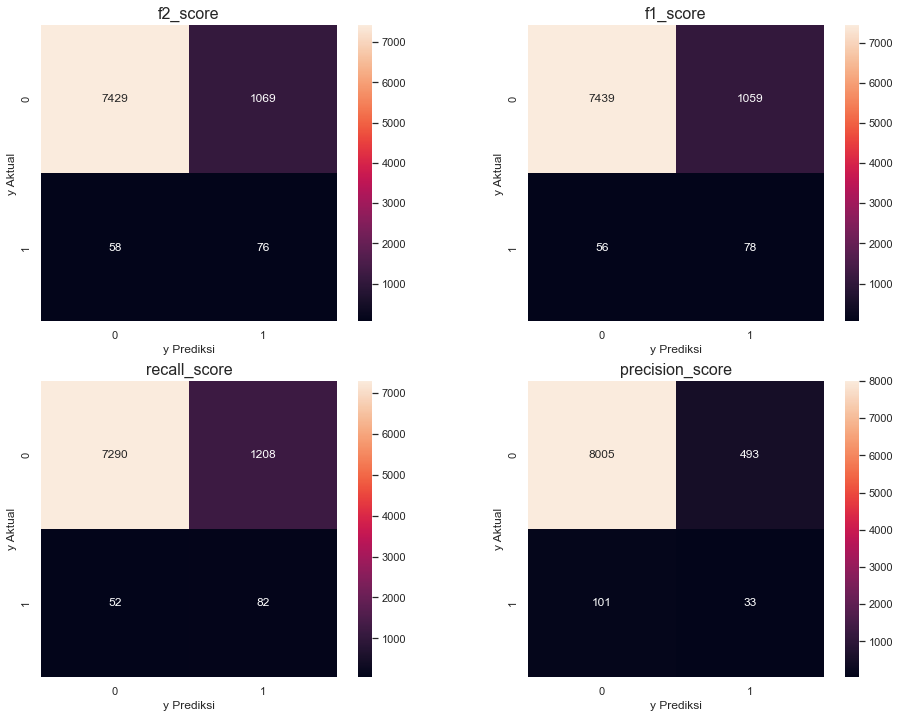

In [372]:
# Showing heatmap of confusion matrix

list_matrix = [matrix_f2, matrix_f1, matrix_recall, matrix_precision ]
list_title = ['f2_score', 'f1_score', 'recall_score', 'precision_score']

plt.figure(figsize=(16,12))

subplot = 1

for matrix in list_matrix:
    
    plt.subplot(2,2,subplot)
    sns.heatmap(matrix, annot=True, fmt='.0f', square=True)
    plt.xlabel('y Prediksi')
    plt.ylabel('y Aktual')
    plt.title(list_title[subplot-1], size=16)

    subplot +=1


In [481]:
# Buat function perhitungan keuntungan 
def calculation(matrix):
    TN = matrix[0][0]
    FN = matrix[1][0]
    FP = matrix[0][1]
    TP = matrix[1][1]

    claim = 1000                                            # Hak klaim tiap pemegang polis per tahun
    polis = (X_test['Net Sales'].mean() * 12).round(1)      # rata-rata polis asuransi di test_set per tahun
    sum_polis = len(X_test)                                 # jumlah pemegang polis pada test_set
    sum_claim = y_test.value_counts()[1]                    # jumlah pemegang polis yang klaim asuransi
    amount_claim = sum_claim * claim                        # jumlah yang harus dikeluarkan untuk klaim asuransi terhadap pemegang polis
    income_asurance = polis * len(y_test)                   # pemasukan dari seluruh polis asuransi dalam 1 tahun
    

    if matrix == 'NO ML':
        
        # Pemasukan Perusahaan
        total_income = income_asurance

        # Pengeluaran Perusahaan
        total_expense = amount_claim

        # Cashflow
        predict_claim_amount = (TN+TP+FN+FP) * claim

        extra_cash = total_income - predict_claim_amount                  # extra cash (kebutuhan dana tambahan untuk memenuhi dana klaim)

        if extra_cash > 0:
            extra_cash = 0
        else:
            extra_cash = np.abs(extra_cash)

        # Keuntungan bersih (net profit)
        net_profit = (total_income - total_expense).round()

        return net_profit, extra_cash

    else:

        # Pemasukan Perusahaan
        profit_investment_percentage = 0.06                                 # capital gain per tahun
        capital_gain = (TN + FN) * polis * profit_investment_percentage     # capital gain per tahun berdasarkan dana polis

        total_income = income_asurance + capital_gain                       # Total pemasukan perusahaan    

        # Pengeluaran Perusahaan
        unexpected_cash = FN * 100                                          # biaya yang dikenakan akibat terjadi dana mendadak (FN)

        total_expense = amount_claim + unexpected_cash
        
        # Cashflow
        predict_claim_amount = (FP+TP) * claim                              # dana yang disiapkan untuk klaim asuransi

        extra_cash = total_income - predict_claim_amount                 # extra cash (kebutuhan dana tambahan untuk memenuhi dana klaim)

        if extra_cash > 0:
            extra_cash = 0
        else:
            extra_cash = np.abs(extra_cash)

        # Keuntungan bersih (net profit)
        net_profit = (total_income - total_expense).round()

        return net_profit, extra_cash
        
        
                

In [483]:
# Menampilkan keuntungan menggunakan Machine Learning pada tiap metric
pd.DataFrame({
    'Metric' : ['f2_score', 'f1_score', 'recall_score', 'precision_score'],
    'Net_Profit' : [calculation(matrix_f2)[0], calculation(matrix_f1)[0], calculation(matrix_recall)[0], calculation(matrix_precision)[0]]
}).sort_values('Net_Profit', ascending=False)

,Metric,Net_Profit
3,precision_score,4396843.0
1,f1_score,4383087.0
0,f2_score,4382648.0
2,recall_score,4378915.0


Terlihat dari perhitungan keuntungan bersih (net profit), metric precision_score merupakan yang terbesar. Karena itu, lebih baik untuk deploy machine learning menggunakan metric precision_score. Setelah itu dapat dihitung berapa peningkatannya jika tidak menggunakan machine learning.

In [469]:
# Persentase peningkatan net profit machine learning metric precision_score terhadap kalkulasi jika tidak menggunakan machine learning
((calculation(matrix_precision)[0] - calculation('NO ML')[0]) / calculation('NO ML')[0] *100).round(1)

5.6

In [474]:
matrix_precision

array([[8005,  493],
       [ 101,   33]], dtype=int64)

Selain itu jika tidak menggunakan machine learning, alokasi dana untuk klaim memerlukan dana tambahan karena pemasukan dari polis Net Sales tidak mencukupi.

Kebutuhan dana untuk klaim semua pemegang polis : $8,632,000 <br>
Pemasukan perusahaan dari dana polis : $4,298,736 <br>

**Sehingga dibutuhkan dana tambahan : $4,333,264**


In [478]:
calculation('NO ML')

(4164736.0, 4333264.0)

# `Conclusion`

Tujuan dari project ini adalah menentukan apakah pemegang polis akan melakukan klaim asuransi atau tidak.

- FP: prediksi pemegang polis akan klaim asuransi (perusahaan menyimpan cadangan kas untuk pemegang polis klaim asuransi, tidak dialokasikan pada intrumen investasi yang aman seperti Obligasi), padahal aktualnya tidak klaim (dampaknya perusahaan kehilangan potensi *capital gain* investasi 6% per tahun).
- FN: prediksi pemegang polis tidak akan klaim asuransi (perusahaan tidak mengalokasikan cadangan kas untuk pemegang polis klaim asuransi), padahal aktualnya klaim (menyediakan cadangan kas $1000 dan kerugian akibat mendadak membutuhkan dana $100)
<br>
<br>
**Pembayaran polis oleh pemegang polis per bulan : $41.5 (rata-rata Net Sales pada test_set) <br>
Pembayaran polis oleh pemegang polis per tahun : $498 (Pemasukan perusahaan) <br>
Ketentuan hak klaim asuransi perjalanan per pemegang polis : $1000 / tahun <br>**


> **Tanpa menggunakan ML**

Sebelum menggunakan ML, perusahaan tidak mengetahui siapa saja pemegang polis yg akan klaim asuransi, sehingga harus menyediakan cadangan kas klaim asuransi untuk semua pemegang polis. Perusahaan tidak mau ambil resiko apabila semua pemegang polis mengajukan klaim asuransi.

- Pemasukan Perusahaan:
    - Pemasukan perusahaan dari pembayaran polis per tahun (TP+FP+TN+FN): $498 x 8632 = $4,298,736 
    **- Total Pemasukan : $4,298,736**

- Pengeluaran Perusahaan:
    - Alokasi dana klaim tepat sasaran pada orang yang klaim asuransi (TP+FN): $1000 x 134 = $134,000 
    **- Total Pengeluaran : $134,000**

- Cashflow Perusahaan:
    - Alokasi dana untuk klaim asuransi (TP+FP+TN+FN): $1000 x 8632 = $8,632,000 (semua diprediksi akan klaim)
    - $8,632,000 > $4,298,736 (income policy), income tidak dapat memenuhi prediksi kebutuhan dana untuk klaim sehingga dibutuhkan dana tambahan sebesar **$4,333,264**

- Keuntungan bersih (Net Profit) Perusahaan:
    - Pemasukan - Pengeluaran : $4,298,736 - $134,000 = $4,164,736

> **Dengan menggunakan ML**

- Pemasukan Perusahaan:
    - Pemasukan perusahaan dari pembayaran polis per tahun (TP+FP+TN+FN): $498 x 8632 = $4,298,736 
    - Capital gain 6% (TN+FN) : 8106 * $498 * 6% = $242,207 <br>
    **- Total Pemasukan : $4,298,736 + $242,207 = $4,540,943**

- Pengeluaran Perusahaan:
    - Alokasi dana klaim tepat sasaran pada orang yang klaim asuransi (TP+FN): $1000 x 134 = $134,000 
    - Kerugian akibat harus mendadak membutuhkan dana untuk klaim (FN) : $100 x 101 = $10,100 <br>
    **- Total Pengeluaran : $134,000 + $10,100 = $144,100**

- Cashflow Perusahaan:
    - Alokasi dana untuk klaim asuransi (TP+FP): $1000 x 526 = $526,000 
    - $526,000 < $4,298,736 (income policy), income dapat mencakup prediksi kebutuhan dana untuk klaim sehingga tidak dibutuhkan dana tambahan.

- Keuntungan bersih (Net Profit) Perusahaan:
    - Pemasukan - Pengeluaran : $4,540,943 - $144,100 = $4,396,843


**Keuntungan bersih meningkat setelah pakai ML**

- Keuntungan bersih sebelum pakai ML: $4,164,736
- Keuntungan bersih setelah pakai ML: $4,396,843
- ML berhasil meningkatkan keuntungan bersih perusahaan sebesar 5.6% --> ($4,396,843 - $4,164,736) / $4,164,736

**Cashflow membaik setelah pakai ML**
- Kebutuhan dana tambahan sebelum pakai ML: $4,333,264
- Kebutuhan dana tambahan setelah pakai ML: -
- ML berhasil menghilangkan dana yang tidak liquid sebelum pakai ML, yaitu sebesar $4,333,264


# `Recommendation`

Hal-hal yang bisa dikembangkan pada project dataset Travel Insurance ini:
- Menambah lagi data karena *imbalance data*, terutama pada kelas minority yang hampir 1% karena menyebabkan machine learning kurang mempelajari bagaimana karakteristik pemegang polis yang mengajukan klaim.
- Menambah fitur-fitur baru untuk dipelajari oleh machine learning agar model dapat lebih mempelajadi perbedaan kelas 1 dan kelas 0, sehingga diharapkan performa model dapat meningkat. Contoh fitur yang mungkin berkaitan: Pekerjaan, Gaji, Agency Type mungkin dapat dirincikan kembali seperti jenis Airlines-nya (agar machine learning dapat mempelajari bagaimana peluang klaim jika menggunakan Airlines tertentu).

# `Save Final Model`

In [511]:
import pickle

In [516]:
# best model
model_voting = grid_search_precision[2]
model_voting

# fit
model_voting.fit(X, y)

# save with pickle
pickle.dump(model_voting, open('model_votingclassifier.sav', 'wb'))

In [531]:
# load model

model_loaded = pickle.load(open('model_votingclassifier.sav', 'rb'))
model_loaded

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['Age', 'Duration',
                                                   'Net Sales',
                                                   'Commision (in value)']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Agency', 'Agency Type',
                                                   'Distribution Channel',
                                                   'Product Name',
                                                   'Destination',
                                     

In [518]:
X.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Continent', 'Net Sales',
       'Commision (in value)', 'Age'],
      dtype='object')

In [521]:
X.describe()

,Duration,Net Sales,Commision (in value),Age
count,43157.000000,43157.000000,43157.000000,43157.000000
mean,47.942281,41.445934,9.358945,38.714948
std,73.595911,47.062256,19.204414,10.087702
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.000000,0.000000,36.000000
75%,52.000000,48.000000,10.500000,42.000000
max,740.000000,599.000000,210.210000,88.000000


In [527]:
X['Destination'].unique()

array(['SINGAPORE', 'MALAYSIA', 'INDIA', 'UNITED STATES',
       'KOREA, REPUBLIC OF', 'THAILAND', 'OTHER', 'JAPAN', 'INDONESIA',
       'VIET NAM', 'AUSTRALIA', 'UNITED KINGDOM', 'HONG KONG', 'CHINA',
       'TAIWAN, PROVINCE OF CHINA', 'PHILIPPINES'], dtype=object)

In [529]:
new_cust = pd.DataFrame({
    'Agency':['EPX'],
    'Agency Type':['Airlines'],
    'Distribution Channel':['Online'],
    'Product Name':['24 Protect'],
    'Duration':[50],
    'Destination':['MALAYSIA'],
    'Continent':['Asia'],
    'Net Sales':[43],
    'Commision (in value)':[20],
    'Age':[20]
})

new_cust

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Continent,Net Sales,Commision (in value),Age
0,EPX,Airlines,Online,24 Protect,50,MALAYSIA,Asia,43,20,20


In [537]:
X.iloc[[70],:]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Continent,Net Sales,Commision (in value),Age
70,EPX,Travel Agency,Online,1 way Comprehensive Plan,1,SINGAPORE,Asia,20.0,0.0,36


In [532]:
model_loaded.predict(new_cust)

array([0])

In [539]:
y.iloc[70]

0

In [538]:
model_loaded.predict(X.iloc[[70],:])

array([0])